Files already downloaded and verified
torch.Size([3, 32, 32])


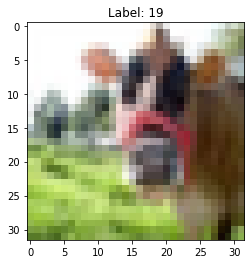

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Define the transforms to be applied to the images
transform = transforms.Compose(
    [transforms.ToTensor()] # Normalize with mean and std
)

# Load the training dataset
batch_size = 32
trainset = datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)

# Get one or two images from the training set
image, label = trainset[0]
print(image.shape)
image = image.permute(1, 2, 0)

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.show()
        
image_size_x = 32
image_size_y = 32 
num_channels = 3


In [3]:
real_datasize = image_size_x*image_size_y*num_channels # a sample in the trainset is a square image of 32*32, and 3 color channels.
input_noise_size = 100;

class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super(UNet, self).__init__()
        
        # Downsample layers
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsample layers
        self.up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(512, 256)
        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(256, 128)
        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, in_channels, kernel_size=1)
        
    def forward(self, x):
        # Downsample
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        #print(f"x2 is {x2.shape}")
        x2 = self.conv2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        x4 = self.pool3(x3)
        x4 = self.conv4(x4)  
        #print(f"x4 is {x4.shape}")
              
        # Upsample
        x5 = self.up5(x4)
        #print(f"x5 is {x5.shape}")
        #print(f"x3 is {x3.shape}")        
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.conv5(x5)
        x6 = self.up6(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.conv6(x6)
        x7 = self.up7(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.conv7(x7)
        
        # Output
        out = self.out(x7)
        return out

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Discriminator(nn.Module):
    def __init__(self, num_channels):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(num_channels, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 2, 1)
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 1)

        self.lrelu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.lrelu(x)
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.conv3(x)
        x = self.lrelu(x)
        x = self.conv4(x)
        x = self.lrelu(x)
        x = self.conv5(x)
        x = self.lrelu(x)
        #print(f"output of conv5 and lrelu is {x.shape}")
        x = x.view(-1, 512 * 2 * 2)
        #print(f"input of fc1 after view is {x.shape}")        
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Define the loss function
#criterion = nn.BCELoss()

# Define the optimizers
lr_dis = 0.0002
lr_gen = 0.00008
beta1 = 0.5
beta2 = 0.999

# define the models:
generator = UNet()
discriminator = Discriminator(num_channels=3)

# Define the loss function and optimizer for the discriminator
criterion_D = nn.BCELoss()

# Define the loss function and optimizer for the generator
criterion_G = nn.BCELoss()

# Create the generator optimizer
optimizer_G = torch.optim.SGD(generator.parameters(), lr=lr_gen)

# Create the discriminator optimizer
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=lr_dis)


In [4]:
num_epochs = 30
print("debug chk")
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        # Train the discriminator
        discriminator.zero_grad()
        real_images = images
        #print(f"size of real_images is {real_images.shape}")        
        real_labels = torch.ones(batch_size, 1)
        noise_input_D = torch.randn(batch_size, 3, 32,32)
        fake_images = generator(noise_input_D).detach()
        #print(f"size of fake_images is {fake_images.shape}")
        fake_labels = torch.zeros(batch_size, 1)
        inputchk = discriminator(real_images)
        #print(inputchk.shape)
        discriminator_loss_real = criterion_D(discriminator(real_images), real_labels)
        discriminator_loss_fake = criterion_D(discriminator(fake_images), fake_labels)
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        discriminator_loss.backward()
        optimizer_D.step()

        # Train the generator
        generator.zero_grad()
        noise_input_G = torch.randn(batch_size, 3, 32,32)        
        fake_images = generator(noise_input_G)
        generator_loss = criterion_G(discriminator(fake_images), real_labels)
        generator_loss.backward()
        optimizer_G.step()

        if i % 2 == 0:
            print(f"Iteration {i} Epoch {epoch}: D Loss = {discriminator_loss}, G Loss = {generator_loss} ")
            
            
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")            

debug chk


C:\Users\Shaer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration 0 Epoch 0: D Loss = 1.3864336013793945, G Loss = 0.7005698680877686 
Iteration 2 Epoch 0: D Loss = 1.386401891708374, G Loss = 0.700630247592926 
Iteration 4 Epoch 0: D Loss = 1.386356234550476, G Loss = 0.7006545066833496 


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 32, 3])


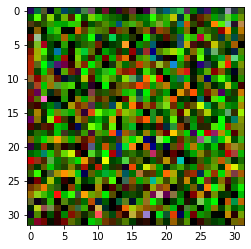

In [12]:

# Generate some images
with torch.no_grad():
    noise_input_test = torch.randn(1, 3, 32,32)   
    generated_images = generator(noise_input_test)
    image_for_plot = generated_images.squeeze()
    image_for_plot = image_for_plot.permute(1, 2, 0)
print(image_for_plot.shape)
plt.imshow(image_for_plot,cmap='gray')
plt.show()
